**Import the necessary libraries**

Here, Numpy is used for getting homography matrix and for linear transformation. OpenCV (cv2) is used to read sample images and select source points, and PIL Image is used to display the source and projected sample images inside the notebook.

In [ ]:
# run this first if following libraries are not yet installed
! pip install numpy opencv-python Pillow

In [1]:
import numpy as np
import cv2
from PIL import Image

**Finding homography matrix**

Our goal here is to find a homography matrix $h$ such that will be used to map source points to destination points. We will use matrix $h$ to transform the array of source points to the array of destination points. The equation for this transformation is:

$$\begin{bmatrix} u' \\ v' \\ w' \end{bmatrix} = h \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} = 
\begin{bmatrix} h_{11} & h_{12} & h_{13} \\ h_{21} & h_{22} & h_{23} \\ h_{31} & h_{32} & 1 \end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}$$

where $u'$, $v'$, and $w'$ are the coordinates after linear transformation, and $x$, $y$, are the coordinates of the source points. The homography matrix $h$ can be found by using the equation $Ah = b$ as shown below:

$$\begin{bmatrix} x_1 & y_1 & 1 & 0 & 0 & 0 & -x_1x_1' & -y_1x_1' \\ 
0 & 0 & 0 & x_1 & y_1 & 1 & -x_1y_1' & -y_1y_1' \\
x_2 & y_2 & 1 & 0 & 0 & 0 & -x_2x_2' & -y_2x_2' \\ 
0 & 0 & 0 & x_2 & y_2 & 1 & -x_2y_2' & -y_2y_2' \\
x_3 & y_3 & 1 & 0 & 0 & 0 & -x_3x_3' & -y_3x_3' \\ 
0 & 0 & 0 & x_3 & y_3 & 1 & -x_3y_3' & -y_3y_3' \\ 
x_4 & y_4 & 1 & 0 & 0 & 0 & -x_4x_4' & -y_4x_4' \\ 
0 & 0 & 0 & x_4 & y_4 & 1 & -x_4y_4' & -y_4y_4' \\ \end{bmatrix} 
\begin{bmatrix} h_{11} \\ h_{12} \\ h_{13} \\ h_{21} \\ h_{22} \\ h_{23} \\ h_{31} \\ h_{32} \end{bmatrix} = 
\begin{bmatrix} x_{1}' \\ y_{1}' \\ x_{2}' \\ y_{2}' \\ x_{3}' \\ y_{3}' \\ x_{4}' \\ y_{4}' \end{bmatrix}$$

where $x_i$, $y_i$, are the coordinates of the source points, and $x_i'$, $y_i'$, are the coordinates of the destination points.

To find $h$, we need to solve the equation $Ah = b$ using the least squares method. The least squares method is used to find the best fit for a set of data points. Particularly, the least squares method that we will use is the Moore-Penrose pseudoinverse method. By using this method, we get

$$h = (A^TA)^{-1}A^Tb$$

The resulting matrix will be concatenated with a 1 at the end and will be reshaped to 3x3 to form the homography matrix $h$.


The function here is used to find the homography matrix that will map image points to the desired destination points.

In [2]:
def find_homography_matrix(src_pts, dst_pts):

    A = np.empty((8,8)) # create an empty matrix A of size 8x8
    b = [] # create an empty list to store the values of destination points

    # next, we need to fill the matrix A with the values from the given points
    for i in range(4):
        x_i = src_pts[i][0] # x coordinate of ith point in source image
        y_i = src_pts[i][1] # y coordinate of ith point in source image
        x_i_prime = dst_pts[i][0] # x coordinate of ith dst point
        y_i_prime = dst_pts[i][1] # y coordinate of ith dst point
        A[2*i] = [x_i, y_i, 1, 0, 0, 0, -x_i*x_i_prime, -y_i*x_i_prime] # update matrix A
        A[2*i+1] = [0, 0, 0, x_i, y_i, 1, -x_i*y_i_prime, -y_i*y_i_prime] # update matrix A
        b.append(x_i_prime) # store the x coordinate of ith point in destination image
        b.append(y_i_prime) # store the y coordinate of ith point in destination image

    # using least square estimation, we can find the solution to the matrix Ah = b
    # we use Moore-Penrose pseudoinverse to find the solution
    h = np.matmul(A.T, A)
    h = np.linalg.inv(h)
    h = np.matmul(h, A.T)
    h = np.matmul(h, b) # finishing here, we get h = (A.T * A)^-1 * A.T * b
    
    h = np.append(h, 1) # append 1 as the last element of h
    H = np.reshape(h, (3,3)) # reshape h to a 3x3 matrix
    
    # Alternatively, we can use the code below and get the same result
    # h = np.linalg.lstsq(A, b, rcond=0)[0] 
    # h = np.concatenate((h, [1]), axis=0)  
    # H = h.reshape(3,3) 

    return H

**Linear transformation**

After finding the homography matrix, we can now use it to transform the image. From the equation above, we have

$$\begin{bmatrix} u' \\ v' \\ w' \end{bmatrix} = 
\begin{bmatrix} h_{11} & h_{12} & h_{13} \\ h_{21} & h_{22} & h_{23} \\ h_{31} & h_{32} & 1 \end{bmatrix}
\begin{bmatrix} x \\ y \\ 1 \end{bmatrix}$$

To get the coordinates of the transformed image (2D), we divide the resulting matrix by $w'$. Thus, the destination coordinates will be:

$$\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} = \frac{1}{w'} \begin{bmatrix} u' \\ v' \\ w' \end{bmatrix} $$

Since we are working on 2D space, we only use the first two rows of the destination matrix.

The function below will transform the image using the homography matrix $h$.

In [3]:
def transform_image(img, H):

    pixels = [] # create an empty list to store the points of transformed pixels

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            pt = np.array([j, i, 1]) # create a point in the form of [x, y, 1]
            pt_prime = np.matmul(H, pt) # multiply the point with the homography matrix
            pt_prime = pt_prime / pt_prime[2] # normalize the point
            pixels.append(pt_prime.astype(int)) # append the point to the list

    pixels = np.array(pixels) # convert the list to a numpy array
    
    # next, create an array that can hold the transformed/mapped image
    img_mapped = np.zeros((max(pixels[:,1])+1, max(pixels[:,0])+1, 3), dtype=np.uint8)

    # next, we fill img_mapped with the pixels from the original image
    img_reshaped = img.reshape(-1, 1, 3) # reshape the original image to a 1D array
    for i in range(len(pixels)):
        if pixels[i, 0] >= 0 and pixels[i, 1] >= 0: # check if the pixel is not out of bounds
            img_mapped[pixels[i, 1], pixels[i, 0]] = img_reshaped[i] # fill the array with the pixels

    return img_mapped

**Selecting four (4) source points and destination points**

The following functions will display the sample image and will allow the user to select four (4) source points and four (4) destination points. The source points will be used to find the homography matrix $h$ and the destination points will be used to transform the image.

In [4]:
def select_src_pts(img):

    img_copy = img.copy() # copy the image
    
    src_pts = [] # create an empty list to store the points
  
    def mouse_callback(event, x, y, flags, param):
        # store the first 4 points clicked by the user
        if event == cv2.EVENT_LBUTTONDOWN and len(src_pts) < 4:
            src_pts.append([x, y]) # append the point to the list in the form of [x, y]
            
            cv2.circle(img_copy, (x, y), 5, (0, 255, 0), -1) # draw a circle on the points selected to guide the user

            # connect the points with a line
            if len(src_pts) > 1:
                cv2.line(img_copy, tuple(src_pts[-1]), tuple(src_pts[-2]), (0, 255, 0), 1)
            if len(src_pts) == 4:
                cv2.line(img_copy, tuple(src_pts[-1]), tuple(src_pts[0]), (0, 255, 0), 1)
            
            cv2.imshow('image', img_copy)

    # next, we create a window for user interaction
    cv2.namedWindow('image')
    cv2.setMouseCallback('image', mouse_callback)
    cv2.imshow('image', img_copy)

    # wait for the user to select 4 points
    while len(src_pts) < 4:
        cv2.waitKey(20)
  
    # after selecting 4 poitns, user is given the option to reselect the points
    # next code gives the instructions to the user        
    cv2.rectangle(img_copy, (0, 0), (275, 65), (255, 255, 255), -1)    
    cv2.putText(img_copy, 'Press r to select again', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    cv2.putText(img_copy, 'Press any other key to continue', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)    

    # show the instructions
    cv2.imshow('image', img_copy)

    # if the user wants to reselect, we call the function again. else, we continue
    if cv2.waitKey(0) == ord('r'):
        src_pts = []
        src_pts = select_src_pts(img)
    else:
        cv2.destroyWindow('image')

    # finally, sort src_pts in this order: bottom left, top left, top right, bottom right
    # note that the points appended are in the form of [x, y], and the origin is at the top left corner
    src_pts = sorted(src_pts, key=lambda x: x[0])
    src_pts[0:2] = sorted(src_pts[0:2], key=lambda x: x[1], reverse=True)
    src_pts[2:4] = sorted(src_pts[2:4], key=lambda x: x[1])

    return src_pts


Next, create a function to get the destination points using the selected source points. The side lengths of the object is determined using the selected points. The maximum vertical and horizontal lengths are determined and used as the side lengths of the destination points.

In [5]:
def get_destination_points(src_pts):

    [bottom_left_src, top_left_src, top_right_src, bottom_right_src] = src_pts # read source points

    # get maximum vertical length of the object (i.e., maximum distance between top and bottom points)
    vlen_max = int(max(np.sqrt((bottom_left_src[0] - top_left_src[0])**2 + (bottom_left_src[1] - top_left_src[1])**2),
              np.sqrt((bottom_right_src[0] - top_right_src[0])**2 + (bottom_right_src[1] - top_right_src[1])**2)))

    # get maximum horizontal length of the object (i.e., maximum distance between left and right points)
    hlen_max = int(max(np.sqrt((top_left_src[0] - top_right_src[0])**2 + (top_left_src[1] - top_right_src[1])**2),
                np.sqrt((bottom_left_src[0] - bottom_right_src[0])**2 + (bottom_left_src[1] - bottom_right_src[1])**2)))

    # get the destination points using the maximum vertical and horizontal lengths, use [x, y] format
    bottom_left_dst = [0,vlen_max-1] # bottom left point of the destination image
    top_left_dst = [0,0] # top left point of the destination image
    top_right_dst = [hlen_max-1,0] # top right point of the destination image
    bottom_right_dst = [hlen_max-1,vlen_max-1] # bottom right point of the destination image

    dst = [bottom_left_dst, top_left_dst, top_right_dst, bottom_right_dst] # collect dst points in a list
    
    return [dst, hlen_max, vlen_max]

**Selecting image and showing the transformed image**

The next functions will be the first and last steps of the program. The first function will display the sample image to be transformed. The second function will display the transformed image.

In [6]:
def select_image(img):

    img = cv2.imread(img) # read the image

    return img

In [7]:
def show_image(img_mapped, hlen_max, vlen_max):
    
    img_mapped = img_mapped[:vlen_max, :hlen_max] # crop the image to the size of the destination image
    img_mapped = cv2.cvtColor(img_mapped, cv2.COLOR_BGR2RGB) # convert the image to RGB
    
    return Image.fromarray(img_mapped)

**Running the program**

After creating the functions, we can now run the program. First, we need to read the sample images. Then, we need to select the source points. After that, we can get the destination points. Finally, we can get the homography matrix and project the sample image.

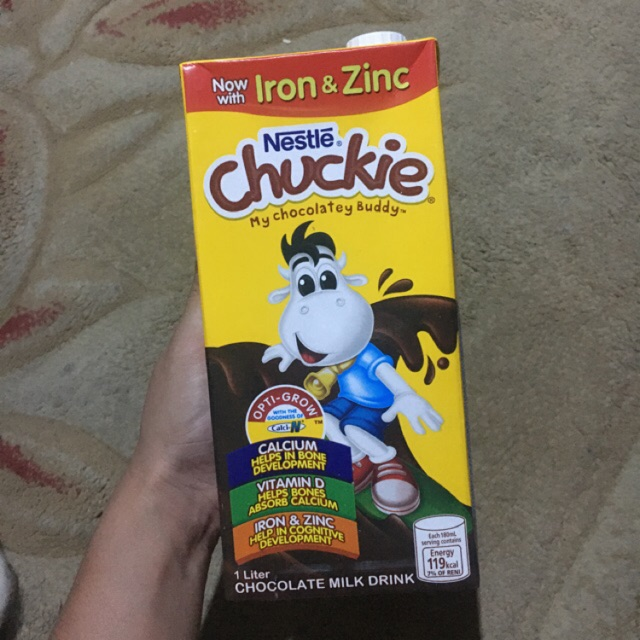

In [8]:
img = select_image('drinkbox.jpg')

# show the sample image
img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
Image.fromarray(img_show)

After running the next code below, a window will appear. Choose four points on the image to be used as source points.

In [9]:
src = select_src_pts(img)
[bottom_left_src, top_left_src, top_right_src, bottom_right_src] = src

# print the selected points
print('Bottom left source point: {}'.format(tuple(bottom_left_src)))
print('Top left source point: {}'.format(tuple(top_left_src)))
print('Top right source point: {}'.format(tuple(top_right_src)))
print('Bottom right source point: {}'.format(tuple(bottom_right_src)))

Bottom left source point: (230, 602)
Top left source point: (181, 64)
Top right source point: (435, 38)
Bottom right source point: (479, 584)


Get the destination points using the selected source points.

In [10]:
[dst, hlen_max, vlen_max] = get_destination_points(src)
[bottom_left_dst, top_left_dst, top_right_dst, bottom_right_dst] = dst

# print the destination points
print('Bottom left destination point: {}'.format(tuple(bottom_left_dst)))
print('Top left destination point: {}'.format(tuple(top_left_dst)))
print('Top right destination point: {}'.format(tuple(top_right_dst)))
print('Bottom right destination point: {}'.format(tuple(bottom_right_dst)))

Bottom left destination point: (0, 546)
Top left destination point: (0, 0)
Top right destination point: (254, 0)
Bottom right destination point: (254, 546)


Use the function above to find the homography matrix.

In [11]:
H = find_homography_matrix(src, dst)
H

array([[ 1.01109577e+00, -9.20886483e-02, -1.77114661e+02],
       [ 1.01293079e-01,  9.89555466e-01, -8.16655971e+01],
       [ 5.11862015e-05, -4.58902615e-05,  1.00000000e+00]])

Finally, transform the image using the homography matrix.

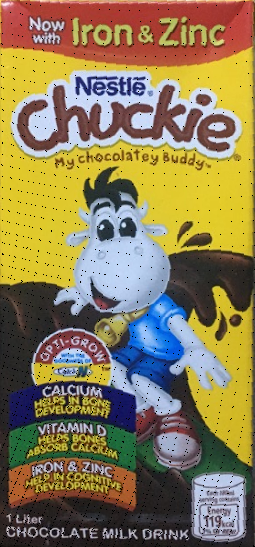

In [12]:
img_mapped = transform_image(img, H)
show_image(img_mapped, hlen_max, vlen_max)